# IMUIF Samna

This implementation will feed the input from the PC and make it possible to read the output of IMUIF module.
Since it's not directly possible to read the output of IMUIF module, we'll implement a dummy network that will return whatever we feed it.

In [1]:
import numpy as np
from rockpool.devices.xylo.imu import XyloSim
from rockpool.devices.xylo.imu.preprocessing import IMUIFSim
from rockpool.timeseries import TSEvent, TSContinuous

In [57]:
import numpy as np

def word_to_numpy_array(word):
    
    # Define patterns for each character (Add more patterns as needed)
    char_patterns = {
        'a': ['01110', '10001', '10001', '11111', '10001'],
        'b': ['11110', '10001', '11110', '10001', '11110'],
        'c': ['01111', '10000', '10000', '10000', '01111'],
        'd': ['11110', '10001', '10001', '10001', '11110'],
        'e': ['11111', '10000', '11110', '10000', '11111'],
        'f': ['11111', '10000', '11110', '10000', '10000'],
        'g': ['01111', '10000', '10011', '10001', '01110'],
        'h': ['10001', '10001', '11111', '10001', '10001'],
        'i': ['01110', '00100', '00100', '00100', '01110'],
        'j': ['00001', '00001', '00001', '10001', '01110'],
        'k': ['10001', '10010', '11100', '10010', '10001'],
        'l': ['10000', '10000', '10000', '10000', '11111'],
        'm': ['10001', '11011', '10101', '10001', '10001'],
        'n': ['10001', '11001', '10101', '10011', '10001'],
        'o': ['01110', '10001', '10001', '10001', '01110'],
        'p': ['11110', '10001', '11110', '10000', '10000'],
        'q': ['01110', '10001', '10101', '10010', '01101'],
        'r': ['11110', '10001', '11110', '10001', '10001'],
        's': ['01111', '10000', '01110', '00001', '11110'],
        't': ['11111', '00100', '00100', '00100', '00100'],
        'u': ['10001', '10001', '10001', '10001', '01110'],
        'v': ['10001', '10001', '10001', '01010', '00100'],
        'w': ['10001', '10001', '10101', '11011', '10001'],
        'x': ['10001', '01010', '00100', '01010', '10001'],
        'y': ['10001', '01010', '00100', '00100', '00100'],
        'z': ['11111', '00010', '00100', '01000', '11111'],
        ' ': ['00000', '00000', '00000', '00000', '00000']
    }

    # Convert the word to lowercase and create the 2D NumPy array
    word = word.lower()
    rows, cols = 5, len(word) * 5  # 5 rows for each character, and calculate the total columns

    result_array = np.zeros((rows, cols), dtype=np.int8)

    for i, char in enumerate(word):
        pattern = char_patterns.get(char, char_patterns[' '])
        for r, row_pattern in enumerate(pattern):
            for c, bit in enumerate(row_pattern):
                result_array[r, i * 5 + c] = int(bit)

    return result_array

In [58]:
def three_channel_word(word1:str, word2:str, word3:str)->np.ndarray:
    pattern1 = word_to_numpy_array(word1)
    pattern2 = word_to_numpy_array(word2)
    pattern3 = word_to_numpy_array(word3)

    pattern = np.concatenate((pattern1, pattern2, pattern3), axis=0)
    pattern = np.flip(pattern, axis=0).T
    return pattern


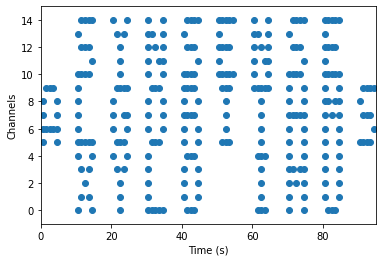

In [152]:
array = three_channel_word('  S Y N S E N S E  ', 'A L G O R I T H M S', '  X Y L O   I M U  ')
TSEvent.from_raster(array).plot()

In [374]:
# The dummy network implementation



# - Network dimensions
Nin = 15  # INC
Nin_ext = 15  # IENC
Nhid = 15  # RSNC
Nout_ext = 15  # OENC
Nout = 15  # ONC

# - Time steps to generate
T = 100
dt = 1 / 200
f_rate = 0.01
alias_rate = 0.0

# - Generate a random network
w_in = np.eye(Nin, dtype="int8") * 2
w_rec = np.eye(Nhid, dtype="int8") * -1
w_out = np.eye(Nout, dtype="int8") * 2

# w_rec = np.random.randint(-10, 10, (Nhid, Nhid))
# w_out = np.random.randint(0, 1, (Nout_ext, Nout))

# w_in = np.eye(8, dtype="int8") * 10
# w_rec = np.full((Nhid, Nhid, num_syn), 0, dtype="int8")
# w_out = np.eye(8, dtype="int8") * 10

# w_in = gen_param_sparse(0, 127, (Nin, Nin_ext), lam=lam)
# w_rec = gen_param_sparse(-24, 24, (Nhid, Nhid), lam=lam)
# w_out = gen_param_sparse(0, 127, (Nout_ext, Nout), lam=lam)

# input_data = np.random.randint(0, 2, (T, Nin))
input_data = array


bias = np.zeros((Nhid,), dtype="int16")
thresh = np.full((Nhid,), 1, dtype="int16")
bias_out = np.zeros((Nout,), dtype="int16")
thresh_out = np.full((Nout,),1, dtype="int16")

dash_mem = np.ones((Nhid,), dtype="int8")
dash_mem_out = np.ones((Nout,), dtype="int8")

dash_syn = np.ones((Nhid,), dtype="int8")
dash_syn_out = np.ones((Nout,), dtype="int8")

w_shift_in = 0
w_shift_rec = 0
w_shift_out = 0

aliases = [[]] * Nhid


# - Build network
mod = XyloSim.from_specification(
    weights_in=w_in,
    weights_rec=w_rec,
    weights_out=w_out,
    dash_mem=dash_mem,
    dash_mem_out=dash_mem_out,
    dash_syn=dash_syn,
    dash_syn_2=dash_syn,
    dash_syn_out=dash_syn_out,
    threshold=thresh,
    threshold_out=thresh_out,
    bias=bias,
    bias_out=bias_out,
    weight_shift_in=w_shift_in,
    weight_shift_rec=w_shift_rec,
    weight_shift_out=w_shift_out,
    aliases=aliases,
    dt=dt,
)

# # - Run simulation
spike_out, state, record_dict = mod.evolve(input_data, record=True)

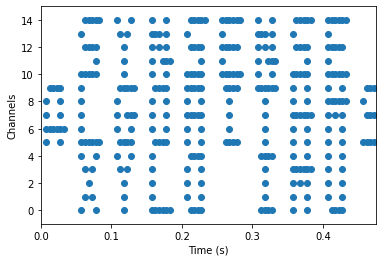

In [375]:
TSEvent.from_raster(spike_out, dt=dt).plot()

In [321]:
# input_data[:-1] == spike_out[1:]

for i in range(len(input_data) - 1):
    print(i)
    print(input_data[i])
    print(spike_out[i+1])
    # print(record_dict["Vmem_out"][i+1])
    print("\n")


0
[0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]


1
[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]


2
[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]


3
[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]


4
[0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]


5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


7
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


9
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


10
[1 0 0 0 1 1 1 1 1 1 1 0 0 1 0]
[1 0 0 0 1 1 1 1 1 1 1 0 0 1 0]


11
[0 1 0 1 0 1 0 0 0 0 1 0 1 0 1]
[0 1 0 1 0 1 0 0 0 0 1 0 1 0 1]


12
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 1]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 1]


13
[0 1 0 1 0 1 0 0 0 0 1 0 1 0 1]
[0 1 0 1 0 1 0 0 0 0 1 0 1 0 1]


14
[1 0 0 0 1 1 0 0 0 0 0 1 0 0 1]
[1 0 0 0 